In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('patient_data.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (20000, 10)

First few rows:
        name  age  has_eye_disease  has_diabetic_retinopathy  \
0  Patient 1   39            False                     False   
1  Patient 2   67             True                     False   
2  Patient 3   44             True                     False   
3  Patient 4   46             True                      True   
4  Patient 5   39            False                     False   

   sugar_percentage  glucose_percentage  cholesterol_percentage  \
0              5.70              147.48                  164.45   
1              8.72               91.52                  235.62   
2             13.83              160.17                  299.13   
3              9.48              106.84                  236.75   
4              5.60              158.65                  182.11   

   obesity_percentage blood_pressure  heart_rate  
0               32.94         122/63          94  
1               39.58          92/80          68  
2              

In [9]:
print("Basic statistics:")
print(df.describe())

print(f"\nDuplicate rows: {df.duplicated().sum()}")

df[['systolic_bp', 'diastolic_bp']] = df['blood_pressure'].str.split('/', expand=True).astype(float)
df = df.drop('blood_pressure', axis=1)

df['has_eye_disease'] = df['has_eye_disease'].astype(int)
df['has_diabetic_retinopathy'] = df['has_diabetic_retinopathy'].astype(int)

print("\nCleaned data info:")
print(df.info())

Basic statistics:
                age  sugar_percentage  glucose_percentage  \
count  20000.000000      20000.000000        20000.000000   
mean      54.924350          9.481480          135.056622   
std       14.624655          3.178785           37.613572   
min       30.000000          4.000000           70.010000   
25%       42.000000          6.720000          102.520000   
50%       55.000000          9.460000          135.280000   
75%       67.000000         12.230000          167.705000   
max       80.000000         15.000000          200.000000   

       cholesterol_percentage  obesity_percentage    heart_rate  
count            20000.000000        20000.000000  20000.000000  
mean               199.907359           27.492396     79.915700  
std                 58.094403            7.218316     11.777238  
min                100.020000           15.000000     60.000000  
25%                149.207500           21.230000     70.000000  
50%                199.760000       

In [10]:
def categorize_bmi(obesity):
    if obesity < 18.5:
        return 'Underweight'
    elif obesity < 25:
        return 'Normal'
    elif obesity < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['obesity_percentage'].apply(categorize_bmi)

def categorize_age(age):
    if age < 40:
        return 'Young'
    elif age < 60:
        return 'Middle-aged'
    else:
        return 'Senior'

df['age_group'] = df['age'].apply(categorize_age)

df['risk_score'] = (
    df['sugar_percentage'] * 0.3 +
    df['glucose_percentage'] * 0.001 +
    df['cholesterol_percentage'] * 0.002 +
    df['obesity_percentage'] * 0.1 +
    df['systolic_bp'] * 0.05 +
    df['has_eye_disease'] * 10 +
    df['has_diabetic_retinopathy'] * 20
)

print("\nFeature engineered columns:")
print(df[['bmi_category', 'age_group', 'risk_score']].head())


Feature engineered columns:
  bmi_category    age_group  risk_score
0        Obese        Young    11.58038
1        Obese       Senior    21.73676
2        Obese  Middle-aged    25.75243
3   Overweight  Middle-aged    42.93434
4  Underweight        Young    10.22787


In [11]:
feature_columns = ['age', 'has_eye_disease', 'has_diabetic_retinopathy', 
                  'sugar_percentage', 'glucose_percentage', 'cholesterol_percentage',
                  'obesity_percentage', 'systolic_bp', 'diastolic_bp', 'heart_rate']

X = df[feature_columns]
y = df['risk_score']  

categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (16000, 10)
Test set: (4000, 10)


In [12]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42)
}

results = {}

for name, model in models.items():
    if 'Regression' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")


Linear Regression:
  MSE: 0.0000
  MAE: 0.0000
  R²: 1.0000

Ridge Regression:
  MSE: 0.0000
  MAE: 0.0005
  R²: 1.0000

Lasso Regression:
  MSE: 0.0531
  MAE: 0.1846
  R²: 0.9997

Decision Tree:
  MSE: 0.0820
  MAE: 0.2304
  R²: 0.9995


In [13]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[model]['MSE'] for model in results],
    'MAE': [results[model]['MAE'] for model in results],
    'R²': [results[model]['R²'] for model in results]
}).round(4)

print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
               Model     MSE     MAE      R²
0  Linear Regression  0.0000  0.0000  1.0000
1   Ridge Regression  0.0000  0.0005  1.0000
2   Lasso Regression  0.0531  0.1846  0.9997
3      Decision Tree  0.0820  0.2304  0.9995


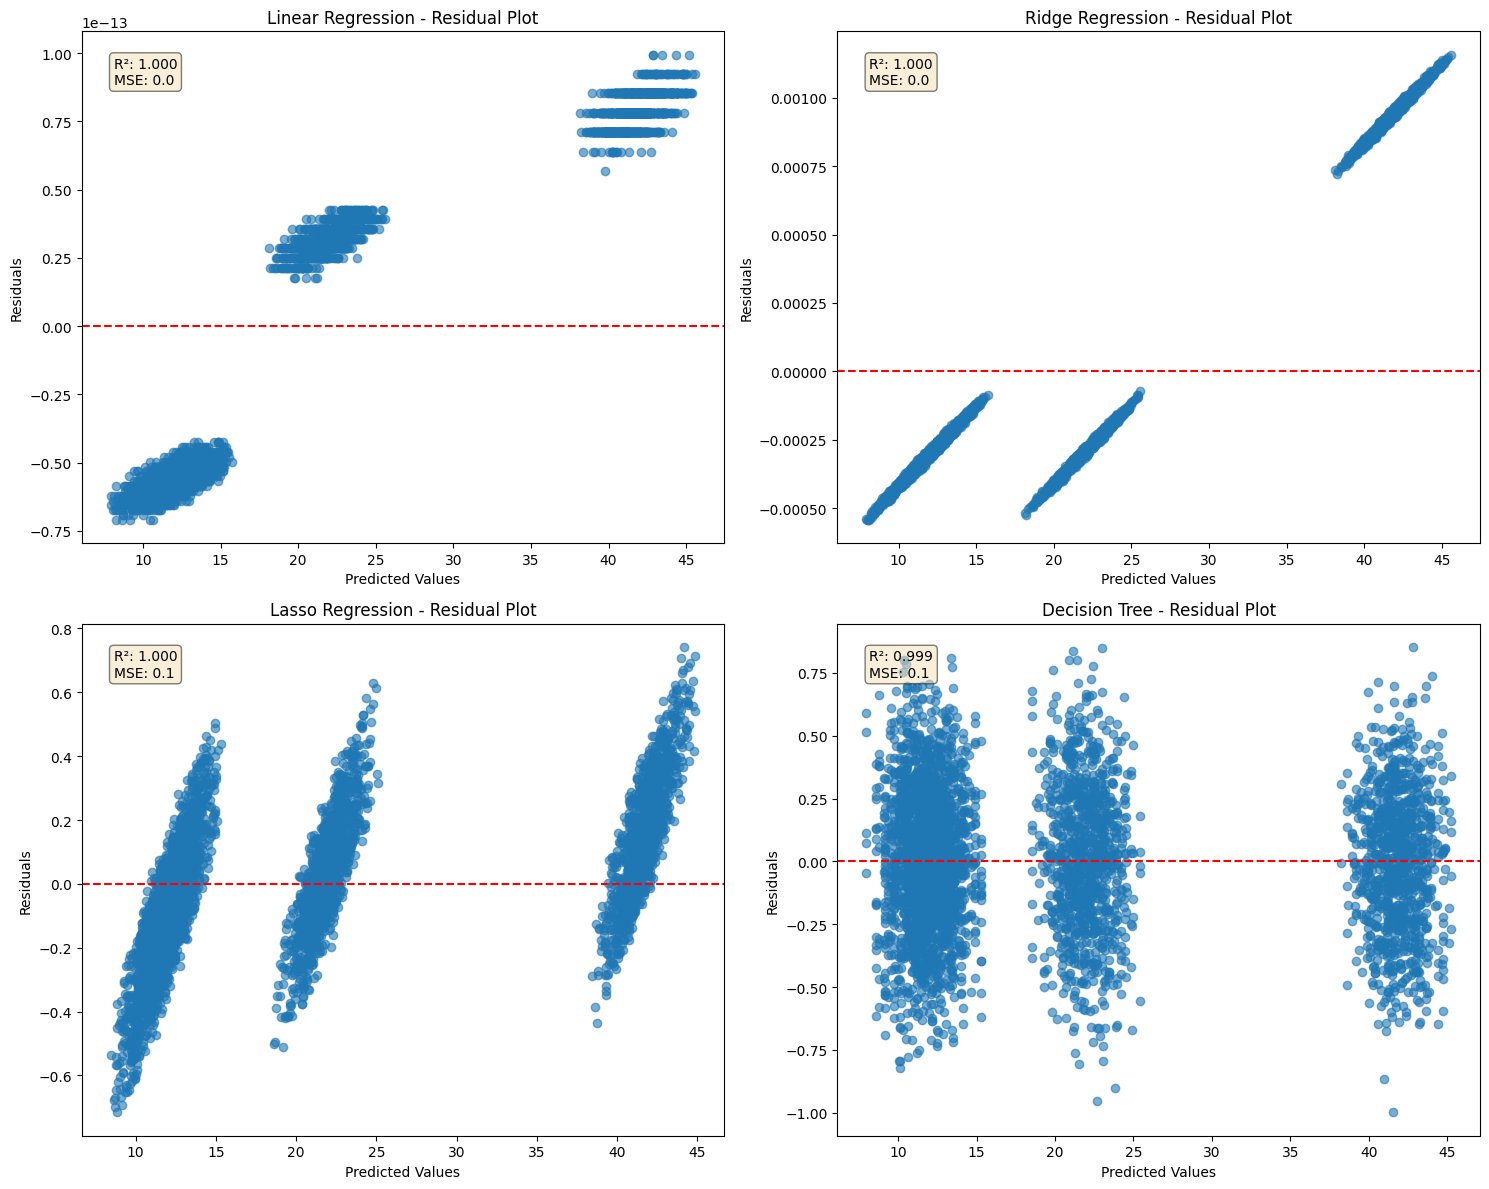

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    y_pred = result['predictions']
    
    residuals = y_test - y_pred
    axes[idx].scatter(y_pred, residuals, alpha=0.6)
    axes[idx].axhline(y=0, color='red', linestyle='--')
    axes[idx].set_xlabel('Predicted Values')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{name} - Residual Plot')
    
    axes[idx].text(0.05, 0.95, f'R²: {result["R²"]:.3f}\nMSE: {result["MSE"]:.1f}', 
                  transform=axes[idx].transAxes, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

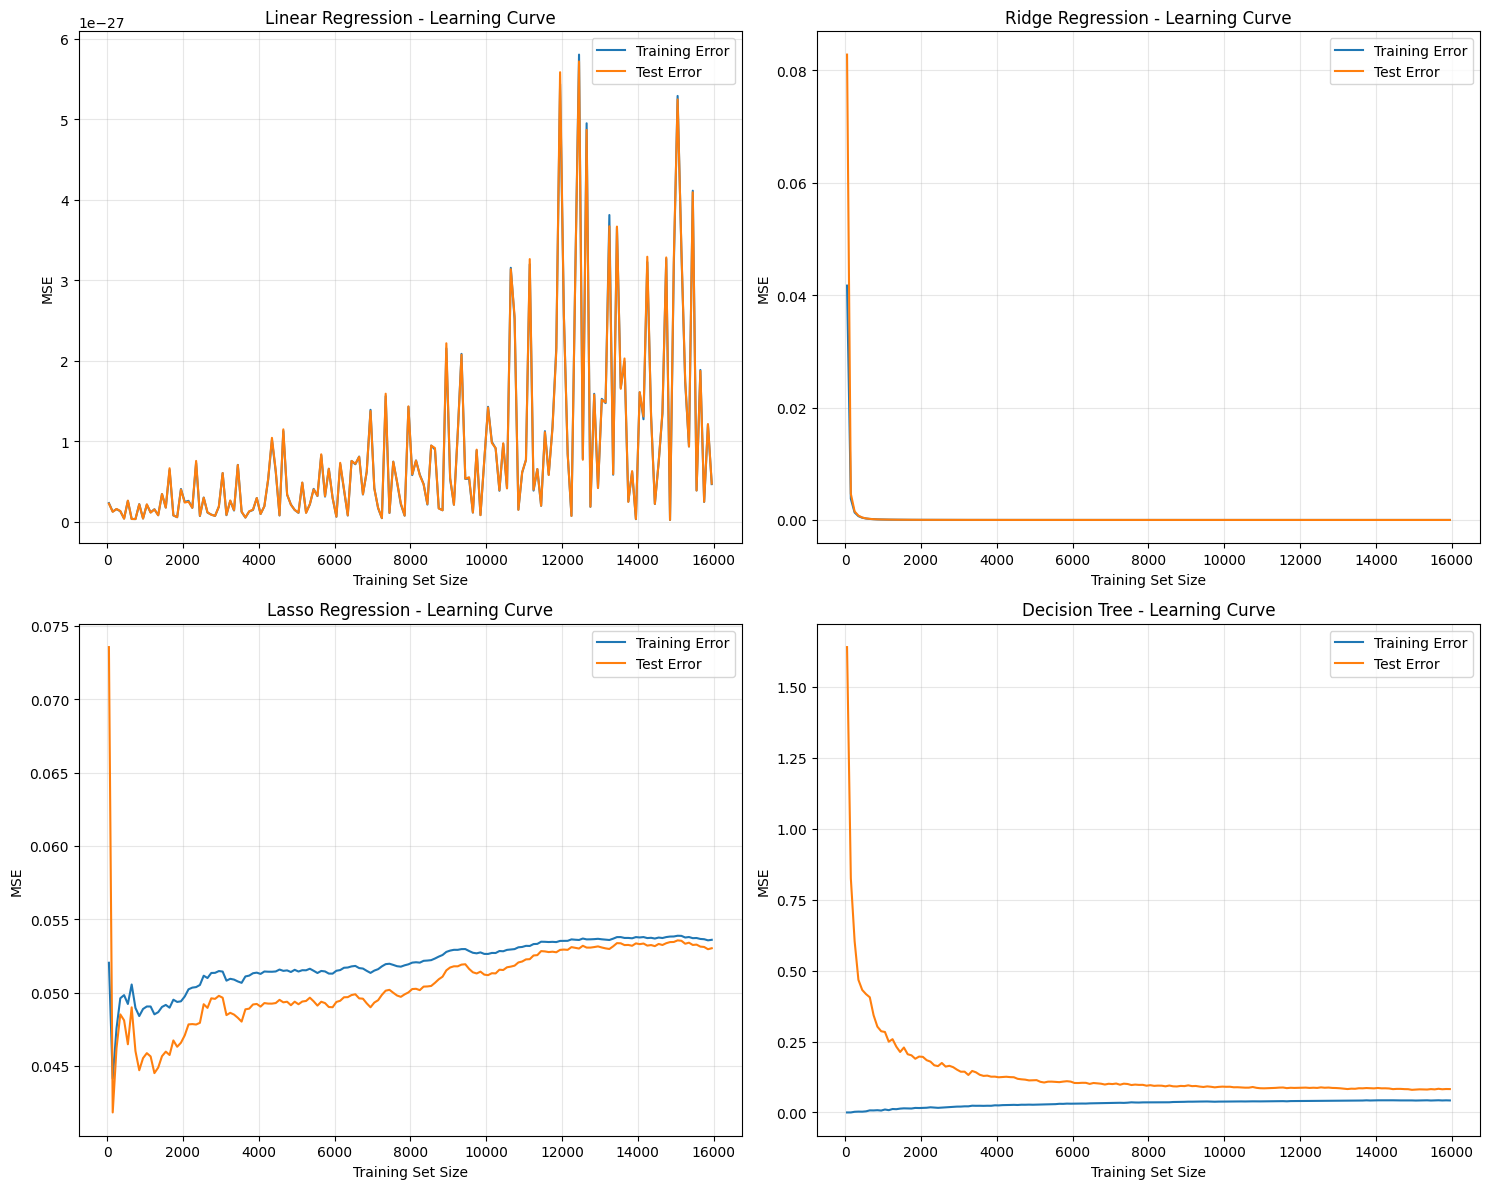

In [15]:
def plot_learning_curves():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models.items()):
        train_errors, test_errors = [], []
        
        if 'Regression' in name:
            X_used = X_train_scaled
            X_test_used = X_test_scaled
        else:
            X_used = X_train
            X_test_used = X_test
            
        for m in range(50, len(X_used), 100):
            if m > len(X_used):
                m = len(X_used)
                
            model.fit(X_used[:m], y_train[:m])
            y_train_predict = model.predict(X_used[:m])
            y_test_predict = model.predict(X_test_used)
            
            train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
            test_errors.append(mean_squared_error(y_test, y_test_predict))
        
        axes[idx].plot(range(50, len(X_used), 100)[:len(train_errors)], train_errors, label='Training Error')
        axes[idx].plot(range(50, len(X_used), 100)[:len(test_errors)], test_errors, label='Test Error')
        axes[idx].set_xlabel('Training Set Size')
        axes[idx].set_ylabel('MSE')
        axes[idx].set_title(f'{name} - Learning Curve')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_learning_curves()

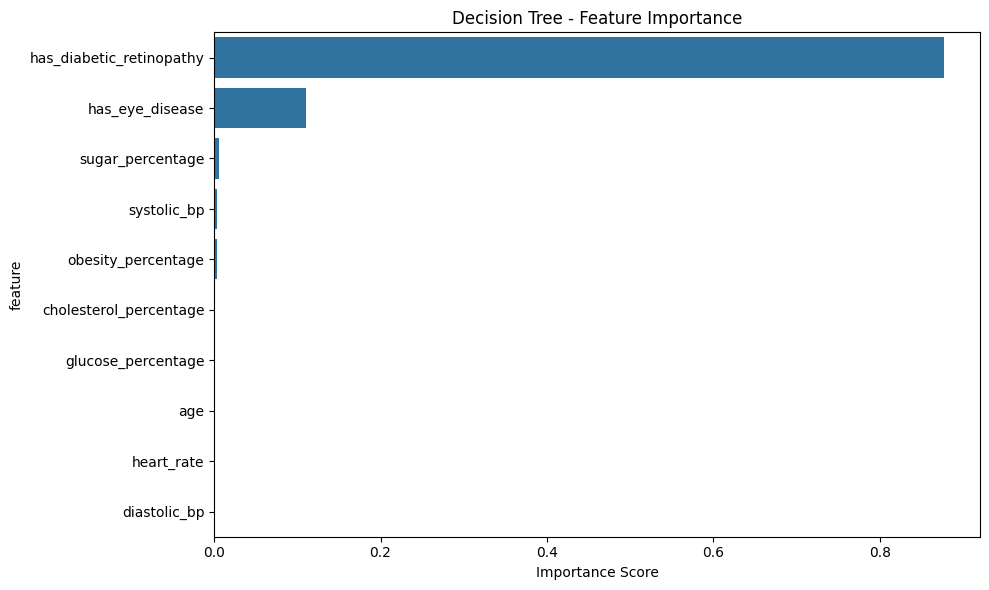

Feature Importance (Decision Tree):
                    feature    importance
2  has_diabetic_retinopathy  8.766848e-01
1           has_eye_disease  1.102684e-01
3          sugar_percentage  6.228774e-03
7               systolic_bp  3.398658e-03
6        obesity_percentage  3.392771e-03
5    cholesterol_percentage  1.991580e-05
4        glucose_percentage  2.721431e-06
0                       age  1.796034e-06
9                heart_rate  1.175748e-06
8              diastolic_bp  9.076283e-07


In [16]:
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Decision Tree - Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Feature Importance (Decision Tree):")
print(feature_importance)

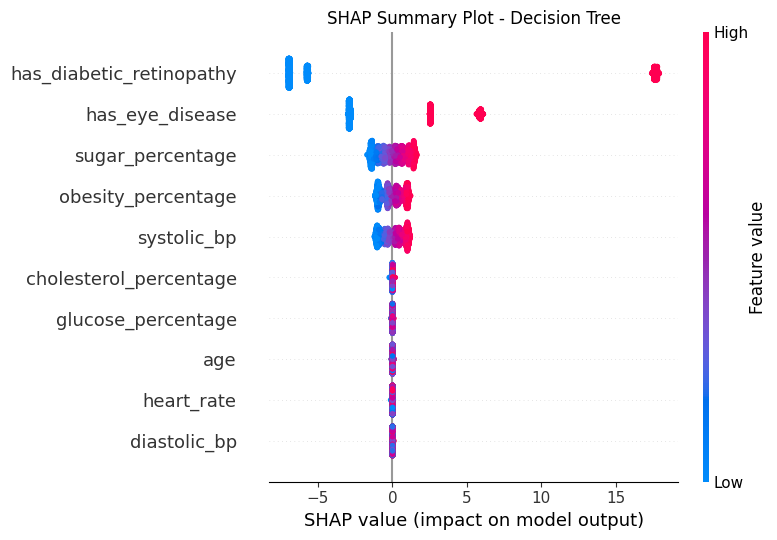

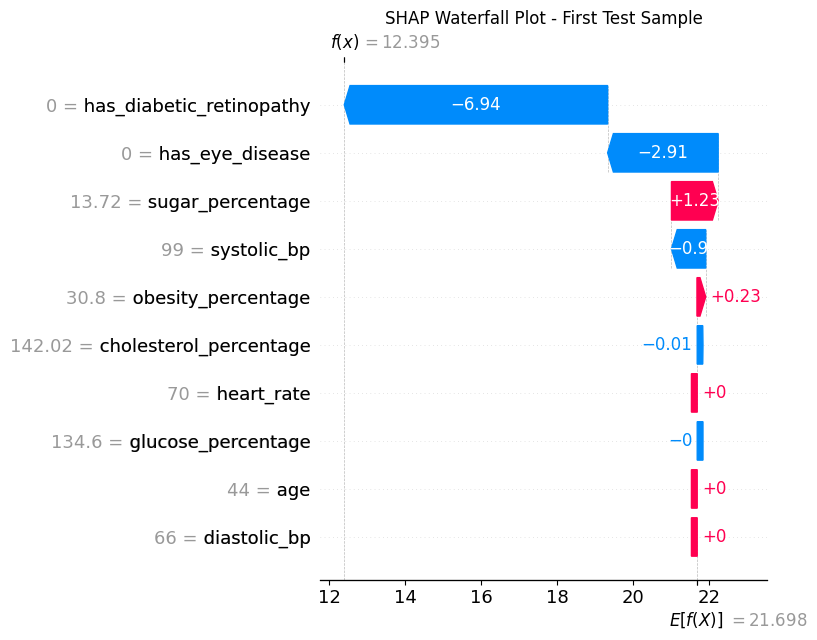

<Figure size 1200x600 with 0 Axes>

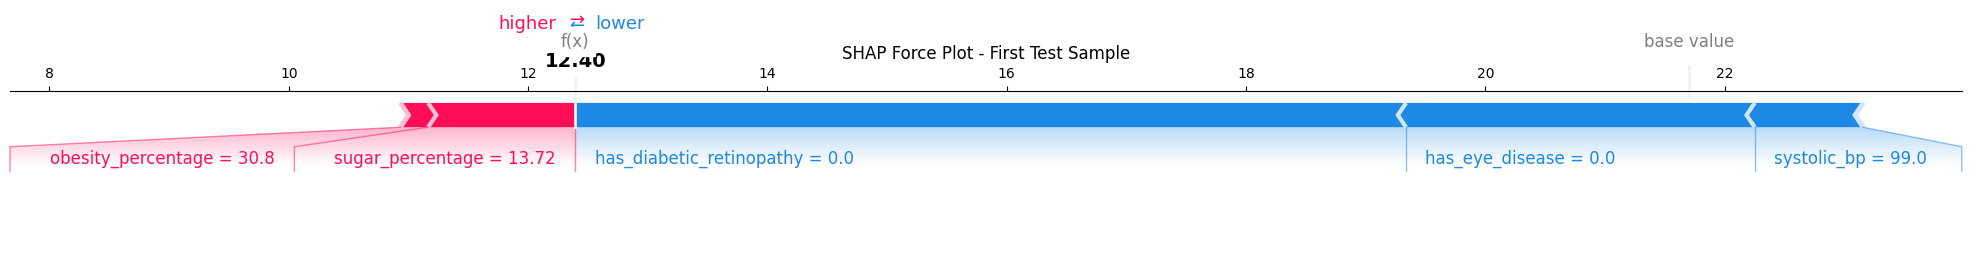

In [17]:
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):  
    shap_vals = shap_values[0]      # class 0 SHAP values
    base_val = explainer.expected_value[0]
else:  
    shap_vals = shap_values
    base_val = explainer.expected_value

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot - Decision Tree")
plt.tight_layout()
plt.show()

expl = shap.Explanation(
    values = shap_vals[0],
    base_values = base_val,
    data = X_test.iloc[0],
    feature_names = X.columns
)

plt.figure(figsize=(12, 8))
shap.plots.waterfall(expl, max_display=12, show=False)
plt.title("SHAP Waterfall Plot - First Test Sample")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
shap.plots.force(expl, matplotlib=True, show=False)
plt.title("SHAP Force Plot - First Test Sample")
plt.tight_layout()
plt.show()

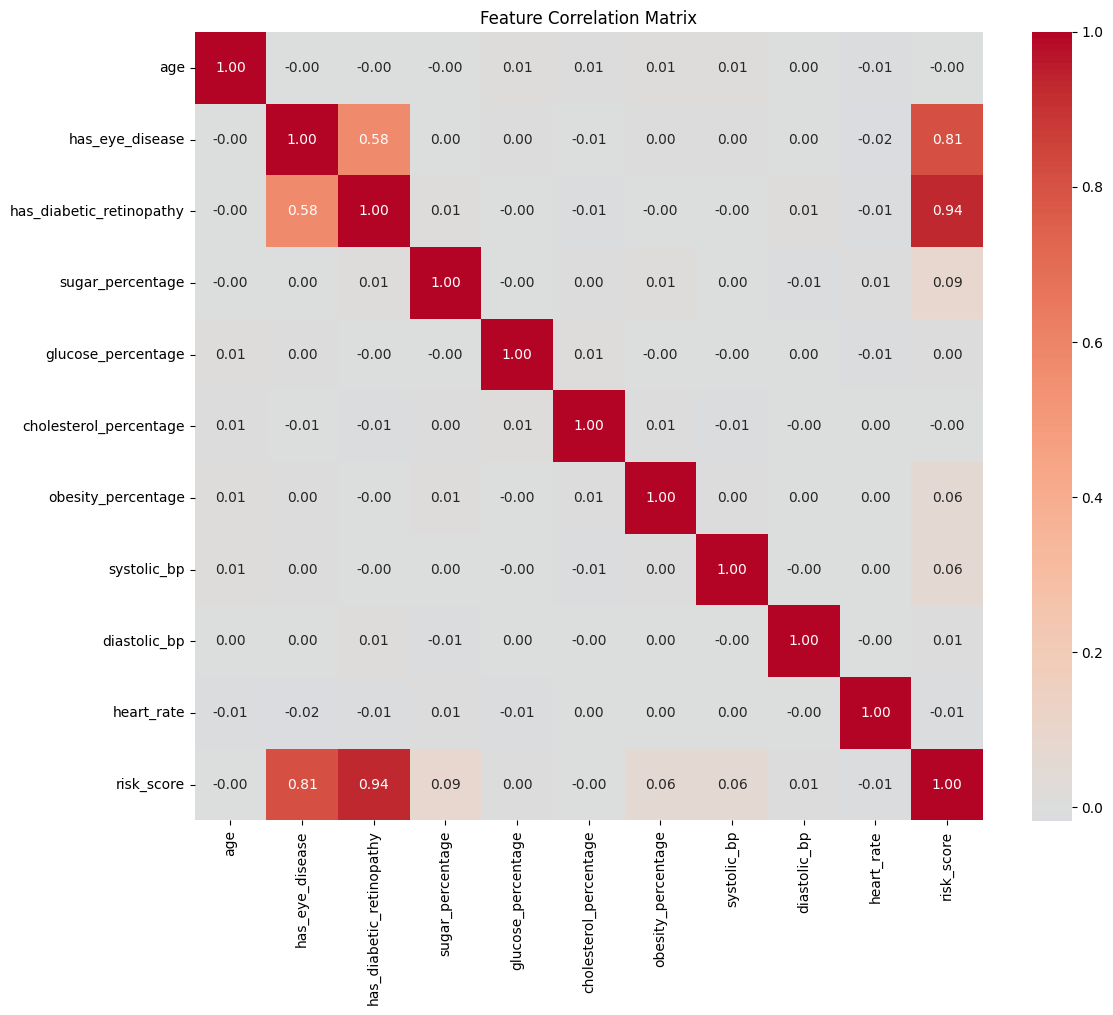

In [18]:
plt.figure(figsize=(12, 10))
correlation_matrix = df[feature_columns + ['risk_score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

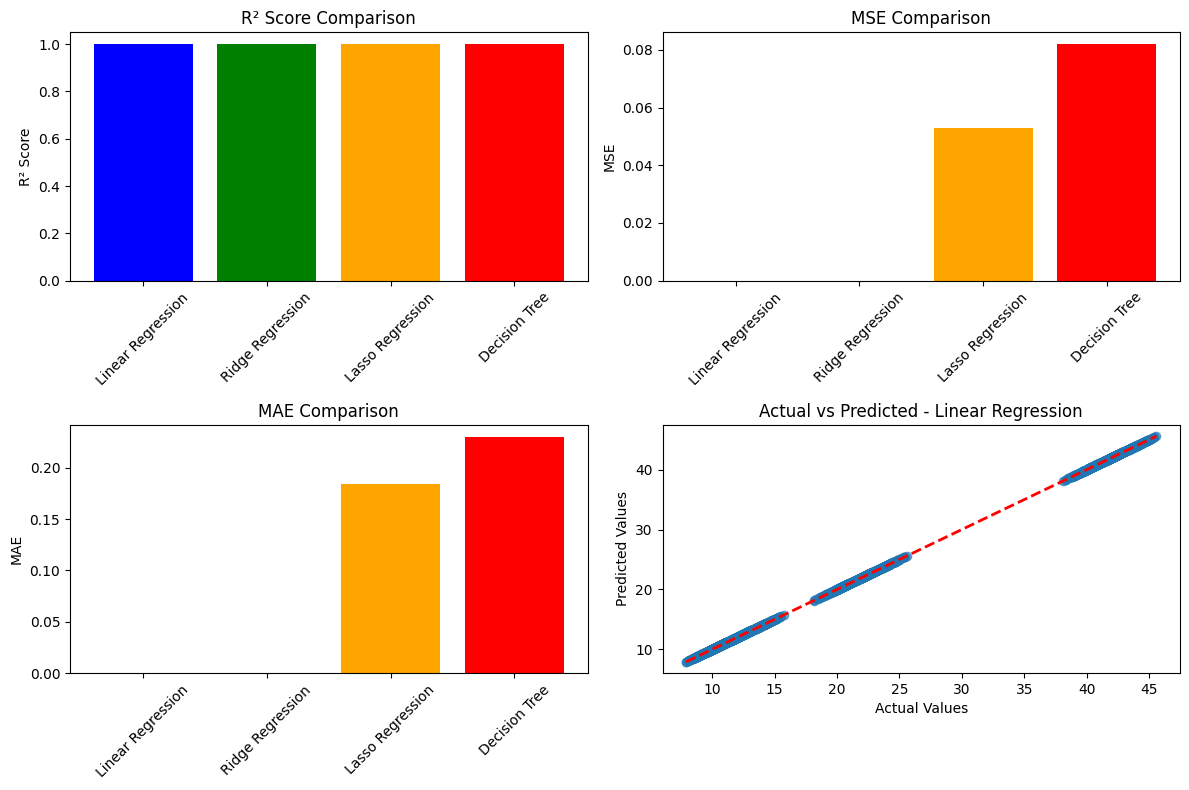

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
r2_scores = [results[model]['R²'] for model in results]
plt.bar(results.keys(), r2_scores, color=['blue', 'green', 'orange', 'red'])
plt.title('R² Score Comparison')
plt.xticks(rotation=45)
plt.ylabel('R² Score')

# MSE comparison
plt.subplot(2, 2, 2)
mse_scores = [results[model]['MSE'] for model in results]
plt.bar(results.keys(), mse_scores, color=['blue', 'green', 'orange', 'red'])
plt.title('MSE Comparison')
plt.xticks(rotation=45)
plt.ylabel('MSE')

# MAE comparison
plt.subplot(2, 2, 3)
mae_scores = [results[model]['MAE'] for model in results]
plt.bar(results.keys(), mae_scores, color=['blue', 'green', 'orange', 'red'])
plt.title('MAE Comparison')
plt.xticks(rotation=45)
plt.ylabel('MAE')

# Actual vs Predicted for best model
best_model_name = max(results, key=lambda x: results[x]['R²'])
plt.subplot(2, 2, 4)
plt.scatter(y_test, results[best_model_name]['predictions'], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted - {best_model_name}')

plt.tight_layout()
plt.show()

In [20]:
print("="*50)
print("ANALYSIS SUMMARY")
print("="*50)

best_model = max(results, key=lambda x: results[x]['R²'])
worst_model = min(results, key=lambda x: results[x]['R²'])

print(f"Best Performing Model: {best_model} (R²: {results[best_model]['R²']:.4f})")
print(f"Worst Performing Model: {worst_model} (R²: {results[worst_model]['R²']:.4f})")

print(f"\nMost Important Features:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print(f"\nDataset Statistics:")
print(f"  Total patients: {len(df)}")
print(f"  Average risk score: {df['risk_score'].mean():.2f}")
print(f"  Patients with eye disease: {df['has_eye_disease'].sum()} ({df['has_eye_disease'].mean()*100:.1f}%)")
print(f"  Patients with diabetic retinopathy: {df['has_diabetic_retinopathy'].sum()} ({df['has_diabetic_retinopathy'].mean()*100:.1f}%)")

ANALYSIS SUMMARY
Best Performing Model: Linear Regression (R²: 1.0000)
Worst Performing Model: Decision Tree (R²: 0.9995)

Most Important Features:
  has_diabetic_retinopathy: 0.8767
  has_eye_disease: 0.1103
  sugar_percentage: 0.0062
  systolic_bp: 0.0034
  obesity_percentage: 0.0034

Dataset Statistics:
  Total patients: 20000
  Average risk score: 21.72
  Patients with eye disease: 9870 (49.4%)
  Patients with diabetic retinopathy: 4910 (24.6%)
